# Imports

In [1]:
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_dir = Path("/zdata/user-data/noam/data/p2cs/")
full_genomes_dir = base_dir / "full_genomes_new"
organism_merged_genomes_dir = base_dir / "organism_merged_genomes_new"
genome_analysis_dir = base_dir / "genome_analysis_results"
mash_analysis_dir = base_dir / "mash_analysis"
mash_distance_dir = mash_analysis_dir / "distance_matrices"  # For genome-level matrices
clusters_dir = base_dir / "clusters"
taxonomy_dir = base_dir / "taxonomy"
embeddings_dir = base_dir / "embeddings" / "esm3-medium" / "all_embeddings"
k_values = [11, 15, 19, 21]

# Load Data

In [3]:
p2cs_filtered_groups = pd.read_pickle(base_dir / "merged_p2cs_data" / "p2cs_filtered_groups.pkl")

p2cs_pairs = pd.read_pickle(base_dir / "merged_p2cs_data" / "p2cs_hk_rr_pairs.pkl")

In [4]:
organism_distance_matrix_path = mash_distance_dir / "distance_matrix_k15.csv"
organism_taxonomy_path = taxonomy_dir / "organism_taxonomy.csv"

distance_mat_df = pd.read_csv(organism_distance_matrix_path, index_col='Unnamed: 0')
print(f"Organism distance matrix loaded successfully from {organism_distance_matrix_path}")

organism_taxonomy_df = pd.read_csv(organism_taxonomy_path)
print(f"Organism taxonomy loaded successfully from {organism_taxonomy_path}")

Organism distance matrix loaded successfully from /zdata/user-data/noam/data/p2cs/mash_analysis/distance_matrices/distance_matrix_k15.csv
Organism taxonomy loaded successfully from /zdata/user-data/noam/data/p2cs/taxonomy/organism_taxonomy.csv


In [5]:
hk_clusters_df = pd.read_csv(clusters_dir / "hkAA_DB_clu.tsv", delimiter='\t', header=None, names=['Gene A', 'Gene B'])
rr_clusters_df = pd.read_csv(clusters_dir / "rrAA_DB_clu.tsv", delimiter='\t', header=None, names=['Gene A', 'Gene B'])

In [6]:
hk_clusters_df.loc[hk_clusters_df['Gene A'] != hk_clusters_df['Gene B']]

,Gene A,Gene B
12,BJ6T_01700,blr0154
13,BJ6T_01700,S23_06480
15,BJ6T_81070,bll1715
21,VF_A0733,VFMJ11_A0855
32,CMN_00657,CMM_0707
...,...,...
40975,Tthe_2147,Thethe_02223
40978,EUR_28330,RHOM_16350
40979,EUR_28330,EUBREC_3649
40985,BUPH_00805,BC1001_4223


# Assign Cluster IDs

In [37]:
hk_cluster_map = dict(zip(hk_clusters_df['Gene A'], hk_clusters_df['Gene A']))
hk_cluster_map.update(dict(zip(hk_clusters_df['Gene B'], hk_clusters_df['Gene A'])))

rr_cluster_map = dict(zip(rr_clusters_df['Gene A'], rr_clusters_df['Gene A']))
rr_cluster_map.update(dict(zip(rr_clusters_df['Gene B'], rr_clusters_df['Gene A'])))

p2cs_filtered_groups['global_cluster'] = pd.NA

hk_mask = (p2cs_filtered_groups['class'] == 'HK')
rr_mask = (p2cs_filtered_groups['class'] == 'RR')

p2cs_filtered_groups.loc[hk_mask, 'global_cluster'] = (
    p2cs_filtered_groups.loc[hk_mask, 'Gene'].map(hk_cluster_map)
)

p2cs_filtered_groups.loc[rr_mask, 'global_cluster'] = (
    p2cs_filtered_groups.loc[rr_mask, 'Gene'].map(rr_cluster_map)
)

hk_missing = p2cs_filtered_groups.loc[hk_mask, 'global_cluster'].isna().sum()
rr_missing = p2cs_filtered_groups.loc[rr_mask, 'global_cluster'].isna().sum()

missing_mask = p2cs_filtered_groups['global_cluster'].isna()
filled_missing = missing_mask.sum()

p2cs_filtered_groups.loc[missing_mask, 'global_cluster'] = (
    p2cs_filtered_groups.loc[missing_mask, 'Gene']
)

print(f"Assigned global clusters for HK genes (missing before fill: {hk_missing})")
print(f"Assigned global clusters for RR genes (missing before fill: {rr_missing})")
print(f"Filled remaining missing clusters with gene identifiers (rows affected: {filled_missing})")

p2cs_filtered_groups[['Gene', 'class', 'global_cluster']].head()


Assigned global clusters for HK genes (missing before fill: 4)
Assigned global clusters for RR genes (missing before fill: 4)
Filled remaining missing clusters with gene identifiers (rows affected: 142)


,Gene,class,global_cluster
0,Asuc_0781,RR,Asuc_0781
1,Asuc_0782,HK,Asuc_0782
2,Asuc_1363,RR,Asuc_1363
3,Asuc_1364,HK,Asuc_1364
4,Asuc_1720,HK,Asuc_1720


# Save

In [ ]:
# p2cs_filtered_groups.to_pickle(base_dir / "merged_p2cs_data" / "p2cs_filtered_groups.pkl")

# Plot

## Cluster size distribution

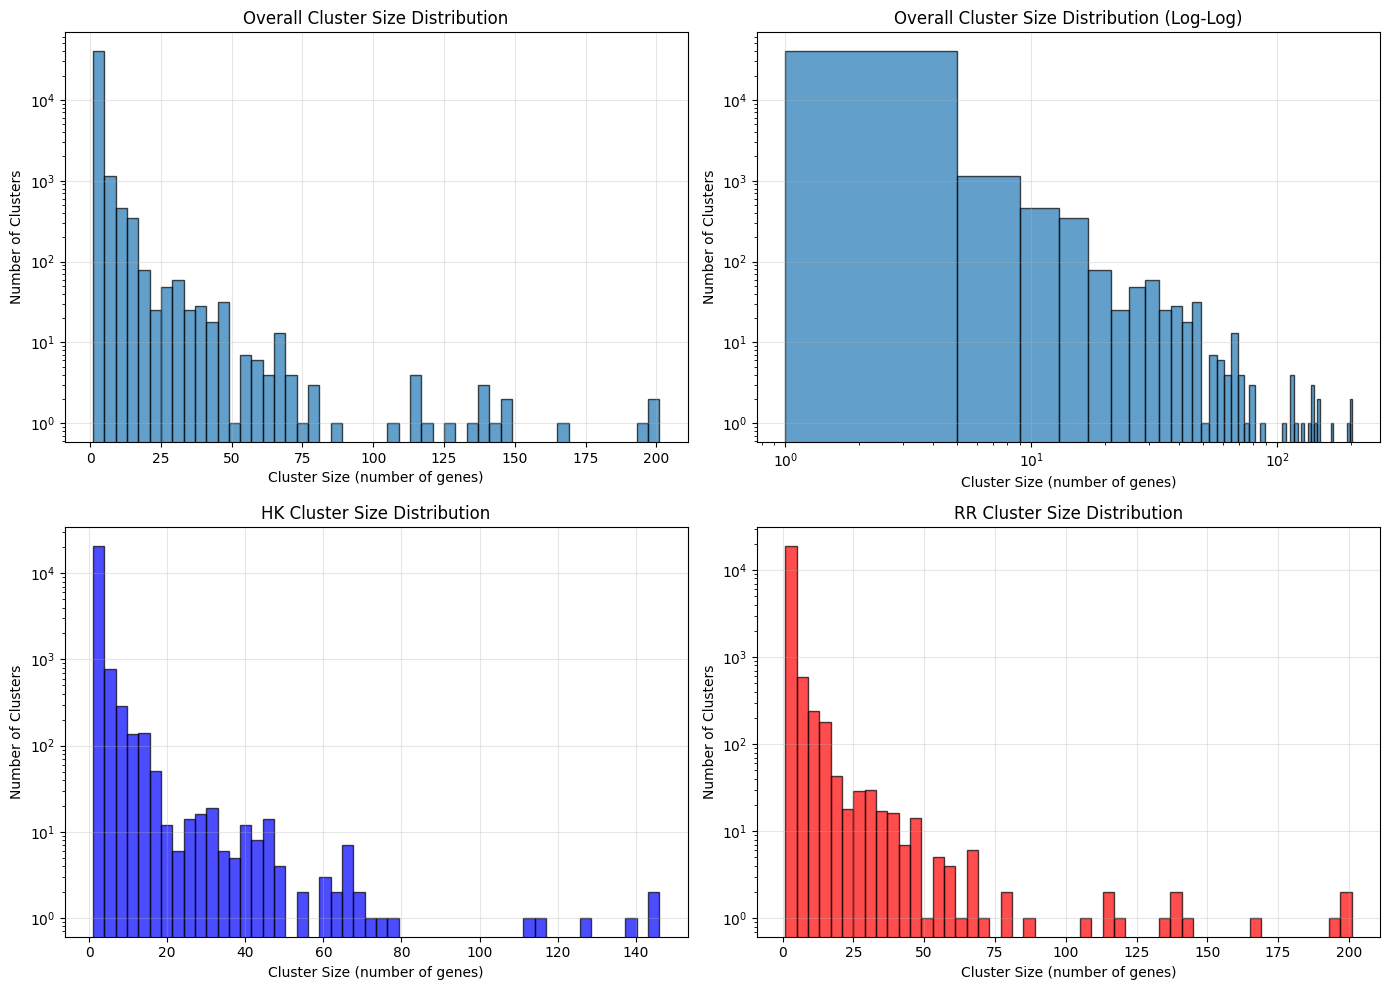

Overall cluster statistics:
  Total clusters: 42701
  Mean cluster size: 1.93
  Median cluster size: 1.00
  Max cluster size: 201
  Min cluster size: 1

HK cluster statistics:
  Total HK clusters: 22342
  Mean HK cluster size: 1.83
  Median HK cluster size: 1.00
  Max HK cluster size: 146

RR cluster statistics:
  Total RR clusters: 20225
  Mean RR cluster size: 2.04
  Median RR cluster size: 1.00
  Max RR cluster size: 201


In [ ]:
cluster_sizes = p2cs_filtered_groups.groupby('global_cluster').size()

hk_cluster_sizes = p2cs_filtered_groups[p2cs_filtered_groups['class'] == 'HK'].groupby('global_cluster').size()
rr_cluster_sizes = p2cs_filtered_groups[p2cs_filtered_groups['class'] == 'RR'].groupby('global_cluster').size()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall cluster size distribution (histogram)
axes[0, 0].hist(cluster_sizes, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Cluster Size (number of genes)')
axes[0, 0].set_ylabel('Number of Clusters')
axes[0, 0].set_title('Overall Cluster Size Distribution')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# Overall cluster size distribution (log-log)
axes[0, 1].hist(cluster_sizes, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Cluster Size (number of genes)')
axes[0, 1].set_ylabel('Number of Clusters')
axes[0, 1].set_title('Overall Cluster Size Distribution (Log-Log)')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# HK cluster size distribution
axes[1, 0].hist(hk_cluster_sizes, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[1, 0].set_xlabel('Cluster Size (number of genes)')
axes[1, 0].set_ylabel('Number of Clusters')
axes[1, 0].set_title('HK Cluster Size Distribution')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# RR cluster size distribution
axes[1, 1].hist(rr_cluster_sizes, bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_xlabel('Cluster Size (number of genes)')
axes[1, 1].set_ylabel('Number of Clusters')
axes[1, 1].set_title('RR Cluster Size Distribution')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Overall cluster statistics:")
print(f"  Total clusters: {len(cluster_sizes)}")
print(f"  Mean cluster size: {cluster_sizes.mean():.2f}")
print(f"  Median cluster size: {cluster_sizes.median():.2f}")
print(f"  Max cluster size: {cluster_sizes.max()}")
print(f"  Min cluster size: {cluster_sizes.min()}")
print(f"\nHK cluster statistics:")
print(f"  Total HK clusters: {len(hk_cluster_sizes)}")
print(f"  Mean HK cluster size: {hk_cluster_sizes.mean():.2f}")
print(f"  Median HK cluster size: {hk_cluster_sizes.median():.2f}")
print(f"  Max HK cluster size: {hk_cluster_sizes.max()}")
print(f"\nRR cluster statistics:")
print(f"  Total RR clusters: {len(rr_cluster_sizes)}")
print(f"  Mean RR cluster size: {rr_cluster_sizes.mean():.2f}")
print(f"  Median RR cluster size: {rr_cluster_sizes.median():.2f}")
print(f"  Max RR cluster size: {rr_cluster_sizes.max()}")


# Find closely homologous systems

In [9]:
# Create mapping from Gene to global_cluster
gene_to_cluster = dict(zip(p2cs_filtered_groups['Gene'], p2cs_filtered_groups['global_cluster']))

# Add cluster IDs to p2cs_pairs
p2cs_pairs['hk_cluster'] = p2cs_pairs['hk_gene'].map(gene_to_cluster)
p2cs_pairs['rr_cluster'] = p2cs_pairs['rr_gene'].map(gene_to_cluster)

# Find pairs of rows where both hk_cluster and rr_cluster match
# We'll use a self-join approach
p2cs_pairs_with_clusters = p2cs_pairs[['hk_gene', 'rr_gene', 'hk_cluster', 'rr_cluster']].copy()

# Merge with itself to find pairs
pairs_merged = p2cs_pairs_with_clusters.merge(
    p2cs_pairs_with_clusters,
    left_on=['hk_cluster', 'rr_cluster'],
    right_on=['hk_cluster', 'rr_cluster'],
    suffixes=('_1', '_2')
)

# Filter out self-pairs (where hk_gene_1 == hk_gene_2 and rr_gene_1 == rr_gene_2)
# and remove duplicate pairs (where (gene1, gene2) appears as (gene2, gene1))
pairs_merged = pairs_merged[
    ~((pairs_merged['hk_gene_1'] == pairs_merged['hk_gene_2']) & 
      (pairs_merged['rr_gene_1'] == pairs_merged['rr_gene_2']))
]

# Remove duplicate pairs by keeping only pairs where hk_gene_1 < hk_gene_2 or 
# (hk_gene_1 == hk_gene_2 and rr_gene_1 < rr_gene_2)
pairs_merged = pairs_merged[
    (pairs_merged['hk_gene_1'] < pairs_merged['hk_gene_2']) |
    ((pairs_merged['hk_gene_1'] == pairs_merged['hk_gene_2']) & 
     (pairs_merged['rr_gene_1'] < pairs_merged['rr_gene_2']))
]

print(f"Total pairs found with matching HK and RR clusters: {len(pairs_merged)}")

pairs_merged

Total pairs found with matching HK and RR clusters: 198559


,hk_gene_1,rr_gene_1,hk_cluster,rr_cluster,hk_gene_2,rr_gene_2
4,BamMC406_0032,BamMC406_0031,BCAL3497,MYA_0027,MYA_0028,MYA_0027
5,BamMC406_0032,BamMC406_0031,BCAL3497,MYA_0027,Bcep1808_0041,Bcep1808_0040
7,BamMC406_0032,BamMC406_0031,BCAL3497,MYA_0027,Bamb_0023,Bamb_0022
8,BamMC406_0032,BamMC406_0031,BCAL3497,MYA_0027,Bcenmc03_0050,Bcenmc03_0049
9,BamMC406_0032,BamMC406_0031,BCAL3497,MYA_0027,Bcen2424_0031,Bcen2424_0030
...,...,...,...,...,...,...
439223,MGAS15252_1566,MGAS15252_1567,M1GAS476_1775,SpyM51688,SpyM51687,SpyM51688
439224,MGAS15252_1566,MGAS15252_1567,M1GAS476_1775,SpyM51688,spyM18_2083,spyM18_2084
439227,MGAS15252_1566,MGAS15252_1567,M1GAS476_1775,SpyM51688,SDEG_0928,SDEG_0927
439228,MGAS15252_1566,MGAS15252_1567,M1GAS476_1775,SpyM51688,SPs1729,SPs1730


## Save

In [ ]:
pairs_merged.to_pickle